# Fitting Thomson Scattering Spectra

Thomson scattering diagnostics record a scattered power spectrum that encodes information about the electron and ion density, temperatures, and flow velocities. This information can be retreived by fitting the measured spectrum with the theoretical spectral density (`thomson.spectral_density`). This notebook demonstrates how to use the `lmfit` package (along with some helpful PlasmaPy functions) to fit 1D Thomson scattering spectra. 


* Put a figure here showing an example of collective vs. non-collective scattering. *

Thomson scattering can be either non-collective (dominated by single electron scattering) or collective (dominated by scattering off of electron plasma waves (EPW) and ion acoustic waves (IAW). In the non-collective regime, the scattering spectrum contains a single peak. However, in the collective regime the spectrum contains separate features caused by the electron and ion populations (corresponding to separate scattering off of EPW and IAW). These features exist on different scales: the EPW feature is dim but covers a wide wavelength range, while the IAW feature is bright but narrow. They also encode partially-degenerate information (eg. the flow velocities of the electrons and ions respectively). The two features are therefore often recorded on separate spectrometers and are fit separately. 


In [256]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

import corner

from lmfit import Parameters
from plasmapy.diagnostics import thomson

## Example: Fitting Spectra in the Collective Regime

To demonstrate the fitting capabilities, we'll first generate some synthetic Thomson data using `thomson.spectral_density`. This data will be in the collective regime, so we will generate two datasets (using the same plasma parameters and probe geometry) that correspond to the EPW and IAW features.

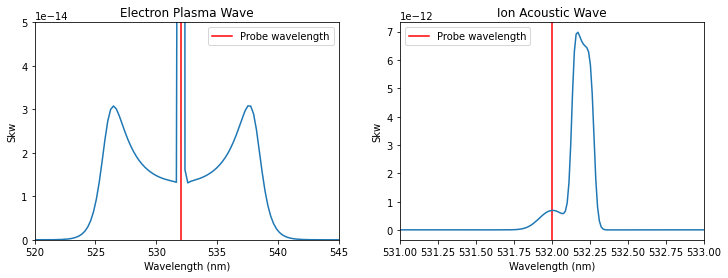

In [257]:
# Generate theoretical spectrum
probe_wavelength = 532*u.nm
epw_wavelengths = np.linspace(probe_wavelength.value-60, probe_wavelength.value+60, num=512)*u.nm
iaw_wavelengths = np.linspace(probe_wavelength.value-3, probe_wavelength.value+3, num=512)*u.nm

probe_vec = np.array([1, 0, 0])
scattering_angle = np.deg2rad(63)
scatter_vec = np.array([np.cos(scattering_angle), np.sin(scattering_angle), 0])

n = 2e17*u.cm**-3
ion_species = ['H+', 'C-12 5+']
Te = 10*u.eV
Ti = np.array([20, 50]) * u.eV
electron_vel = np.array([[0, 0, 0]])*u.km/u.s
ion_vel =  np.array([[0, 0, 0], [200, 0, 0]])*u.km/u.s
ifract = [0.3, 0.7]

alpha, epw_skw = thomson.spectral_density(epw_wavelengths, probe_wavelength,
                     n, Te, Ti, ion_species=ion_species,
                     ifract=ifract,
                     electron_vel=electron_vel,ion_vel=ion_vel,
                     probe_vec=probe_vec, scatter_vec=scatter_vec)

alpha, iaw_skw = thomson.spectral_density(iaw_wavelengths, probe_wavelength,
                     n, Te, Ti, ion_species=ion_species,
                     ifract=ifract,
                     electron_vel=electron_vel,ion_vel=ion_vel,
                     probe_vec=probe_vec, scatter_vec=scatter_vec)

# PLOTTING
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
fig.subplots_adjust(wspace=0.2)

for a in ax:
    a.set_xlabel("Wavelength (nm)")
    a.set_ylabel("Skw")
    a.axvline(x=probe_wavelength.value, color='red', label='Probe wavelength')
    
ax[0].set_xlim(520, 545)
ax[0].set_ylim(0, 5e-14)
ax[0].set_title("Electron Plasma Wave")
ax[0].plot(epw_wavelengths.value, epw_skw)
ax[0].legend()

ax[1].set_xlim(531, 533)
ax[1].set_title("Ion Acoustic Wave")
ax[1].plot(iaw_wavelengths.value, iaw_skw)
ax[1].legend()

Note that these plots are showing the same spectral distribution, just over different wavelength ranges: the large peak in the center of the EPW spectrum is the IAW spectrum. Next we'll add some noise to the spectra to simulate an experimental measurement.

In [258]:
# Add noise to both signals
epw_skw +=  (np.random.normal(loc=0, scale=0.5, size=epw_wavelengths.size))*np.max(np.nan_to_num(epw_skw,0))*0.003
iaw_skw +=  (np.random.normal(loc=0, scale=1, size=iaw_wavelengths.size))*np.max(iaw_skw)*0.05

During experiments, the IAW feature is typically blocked on the EPW detector using a notch filter to prevent it from saturating the measurement. We'll mimic this by setting the center of the EPW spectrum to `np.nan`. The fitting algorithm applied later will recognize these values and not include them in the fit.

The more of the EPW spectrum we exclude, the less sensitive the fit will become. So, we want to block as little as possible while still obscuring the IAW feature.

In [259]:
notch_range = (531, 533)
x0 = np.argmin(np.abs(epw_wavelengths.value - notch_range[0]))
x1 = np.argmin(np.abs(epw_wavelengths.value - notch_range[1]))
epw_skw[x0:x1] = np.nan

Finally, we need to get rid of the units and normalize the data on each detector to its maximum value (this is a requirement of the fitting algorithm). We're using `np.nanmax` here to ignore the NaN values in `epw_skw`.

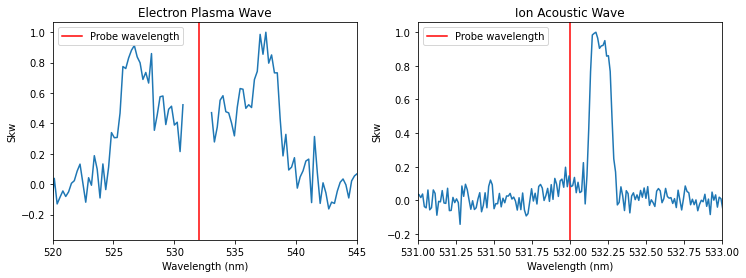

In [260]:
epw_skw = epw_skw.value
epw_skw *= 1/np.nanmax(epw_skw)
iaw_skw = iaw_skw.value
iaw_skw *= 1/np.nanmax(iaw_skw)

# Plot again
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
fig.subplots_adjust(wspace=0.2)

for a in ax:
    a.set_xlabel("Wavelength (nm)")
    a.set_ylabel("Skw")
    a.axvline(x=probe_wavelength.value, color='red', label='Probe wavelength')
    
ax[0].set_xlim(520, 545)
ax[0].set_title("Electron Plasma Wave")
ax[0].plot(epw_wavelengths.value, epw_skw)
ax[0].legend()

ax[1].set_xlim(531, 533)
ax[1].set_title("Ion Acoustic Wave")
ax[1].plot(iaw_wavelengths.value, iaw_skw)
ax[1].legend()

We'll start by fitting the EPW feature, then move on to the IAW feature. This is typically the process followed when analyzing experimental data, since the EPW feature depends on fewer parameters.

### Fitting the EPW Feature

In order to fit this data in `lmfit`, we need to define a [`lmfit.Parameters`](https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameters) object, which is an ordered dictionary of [`lmfit.Parameter`](https://lmfit.github.io/lmfit-py/parameters.html#lmfit.parameter.Parameter) objects. Each `Parameter` has a number of elements, the most important of which for our purposes are
- "name" (str) -> The name of the parameter (and the key in `Parameters` dictionary)
- "value" (float) -> The initial value of the parameter.
- "vary" (boolean) -> Whether or not the parameter will be varied during fitting.
- "min", "max" (float) -> The minimum and maximum bounds for the parameter during fitting.

Since `Parameter` objects can only be scalars, arrays of multiple quantities must be broken apart into separate `Parameter` objects. To do so, this fitting routine adopts the following convention:

`Te = [1,2] -> "Te_0"=1, "Te_1" = 2`

Specifying large arrays (like velocity vectors for multiple ion species) is clearly tedious in this format, and specifying non-numeric values (such as `ion_species`) is impossible. Therefore, this routine also takes a `settings` dictionary as a way to pass non-varying input to the `thomson.spectral_density` function.

A list of required and optional parameters and settings is provided in the docstring for the model functions. For example:

In [261]:
help(thomson.thomson_model)

Help on function thomson_model in module plasmapy.diagnostics.thomson:

thomson_model(wavelengths, settings, params)
    Returns a `lmfit` Model function for the EPW feature.
    
    
    Parameters
    ----------
    
    wavelength : 'astropy.units.Quantity' array
        Array of wavelengths over which to to evaluate the model
    
    
    settings : dict
        A dictionary of non-variable inputs to the spectral density function
        which must include the following:
    
            - probe_wavelength: Probe wavelength in nm
            - probe_vec : (3,) unit vector in the probe direction
            - scatter_vec: (3,) unit vector in the scattering direction
            - ion_species : list of Particle strings describing each ion species
    
        and may contain the following optional variables
            - electron_vdir : (e#, 3) array of electron velocity unit vectors
            - ion_vdir : (e#, 3) array of ion velocity unit vectors
    
    
        These quantit

We will now create the `Parameters` object and settings dictionary using the values defined earlier when creating the sample data. We will choose to vary both the density and electron temperature, and will intentionally set the wrong initial values for both parameters. Note that, even though only one electron population is inclued, we must still name the temperature variable `Te_0`

In [262]:
settings = {}
settings['probe_wavelength'] = probe_wavelength
settings['probe_vec'] = probe_vec
settings['scatter_vec'] = scatter_vec
settings['ion_species'] = ion_species
settings['ion_vdir'] = np.array([[0, 0, 0], [1, 0, 0]])
#settings['block_regions'] = [(531, 533)]

params = Parameters()
params.add('n', value=4e17, vary=True, min=5e16, max=1e18)
params.add('Te_0', value=5, vary=True, min=0.5, max=25)
params.add('Ti_0', value=10, vary=False, min=5, max=60)
params.add('Ti_1', value=65, vary=False, min=5, max=60)
params.add('ifract_0', value=0.5, vary=False, min=0.2, max=0.8)
params.add('ifract_1', value=0.5, vary=False, min=0.2, max=0.8, expr='1.0 - ifract_0')
params.add('ion_speed_0', value=0, vary=False)
params.add('ion_speed_1', value=0, vary=False, min=0, max=1e6)

`lmfit` allows the value of a parameter to be fixed using a [constraint](https://lmfit.github.io/lmfit-py/constraints.html) using the `expr` keyword as shown in the definition of `ifract_1` above. In this case, `ifract_1` is not actually a free parameter, since its value is fixed by the fact that `ifract_0 + ifract_1 = 1.0`. This constraint is made explicit here, but the `thomson.thomson_model` function will automatically enforce this constraint for `efract` and `ifract` variables.

We can now use these objects to initialize a [`lmfit.Model`](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model) object based on the `thomson.spectral_density` function. This process is non-trivial, but PlasmaPy provides a wrapper function that takes care of everything.

In [263]:
model = thomson.thomson_model(epw_wavelengths, settings, params)

With the model created, the fit can be easily performed using the [`model.fit`](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model.fit) function. This function takes several keyword options that are worth mentioning: 

- "method" -> A string that defines the fitting method, from the list of options [here](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.minimize)

- "max_nfev" -> The maximum number of iterations allowed.

In addition, of course we also need to include the data to be fit (`epw_skw`, without units), the independent variable (`wavelengths`) and the parameter object. It is important to note that the data to be fit should be a `np.ndarray` (unit-less) and normalized.

In [264]:
epw_result = model.fit(epw_skw, params=params, wavelengths=epw_wavelengths,  
                   method='differential_evolution')

The return from this function is a [`lmfit.ModelResult`](https://lmfit.github.io/lmfit-py/model.html#lmfit.model.ModelResult) object, which is a convenient container holding lots of information! To start with, we can see the best-fit parameters, number of iterations, the chiSquared goodness-of-fit metric, and plot the best-fit curve.

In [265]:
print(f"Best fit parameters:\n{epw_result.best_values}")
print(f"Number of fit iterations:{epw_result.nfev}")
print(f"Reduced Chisquared:{epw_result.redchi:.4f}")

# Extract the best fit curve by evaluating the model at the final parameters
best_fit_skw = epw_result.best_fit

Best fit parameters:
{'n': 2.078804544223103e+17, 'Te_0': 9.38679640372275, 'Ti_0': 10, 'Ti_1': 60, 'ifract_0': 0.5, 'ifract_1': 0.5, 'ion_speed_0': 0, 'ion_speed_1': 0, 'efract_0': 1.0, 'electron_speed_0': 0.0}
Number of fit iterations:381
Reduced Chisquared:0.0096


Note that the best_fit curve skips the NaN values in the data, so the array is shorter than `epw_skw`. In order to plot them against the same wavelengths, we need to create an array of indices where `epw_skw` is not NaN.

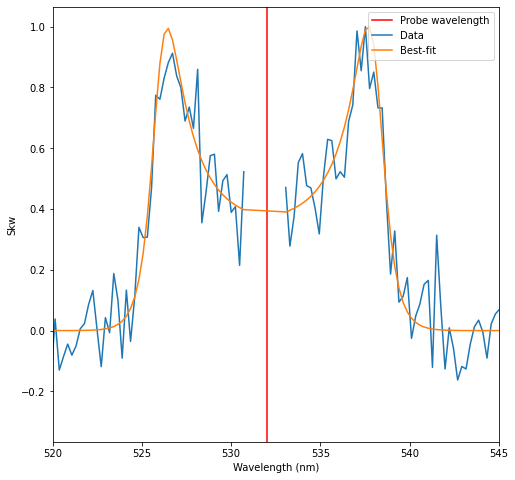

In [266]:
# Get all the non-nan indices (the best_fit_skw just omits these values)
not_nan = np.argwhere(np.logical_not(np.isnan(epw_skw)))

# Plot
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Skw")
ax.axvline(x=probe_wavelength.value, color='red', label='Probe wavelength')
    
ax.set_xlim(520, 545)

ax.plot(epw_wavelengths.value, epw_skw, label='Data')
ax.plot(epw_wavelengths.value[not_nan], best_fit_skw, label='Best-fit')
ax.legend(loc='upper right')

The resulting fit is very good, even though many of the ion parameters are still pretty far from their actual values!

## Fitting the IAW feature

We will now follow the same steps to fit the IAW feature

In [246]:
settings = {}
settings['probe_wavelength'] = probe_wavelength
settings['probe_vec'] = probe_vec
settings['scatter_vec'] = scatter_vec
settings['ion_species'] = ion_species
settings['ion_vdir'] = np.array([[0, 0, 0], [1, 0, 0]])

params = Parameters()
params.add('n', value=n_fit, vary=False)
params.add('Te_0', value=Te_0_fit, vary=False)
params.add('Ti_0', value=10, vary=True, min=5, max=60)
params.add('Ti_1', value=10, vary=True, min=5, max=60)
params.add('ifract_0', value=0.5, vary=True, min=0.2, max=0.8)
params.add('ifract_1', value=0.5, vary=True, min=0.2, max=0.8, expr='1.0 - ifract_0')
params.add('ion_speed_0', value=0, vary=False)
params.add('ion_speed_1', value=0, vary=True, min=0, max=1e6)

model = thomson.thomson_model(iaw_wavelengths, settings, params)

iaw_result = model.fit(iaw_skw, params=params, wavelengths=iaw_wavelengths,  method='differential_evolution')

Best fit parameters:
{'n': 1.999952432940617e+17, 'Te_0': 10.000142909895862, 'Ti_0': 21.212928638466728, 'Ti_1': 48.48870792563692, 'ifract_0': 0.3087155909481292, 'ifract_1': 0.6912844090518708, 'ion_speed_0': 0, 'ion_speed_1': 199774.2814176175, 'efract_0': 1.0, 'electron_speed_0': 0.0}
Number of fit iterations:1395
Reduced Chisquared:0.0001


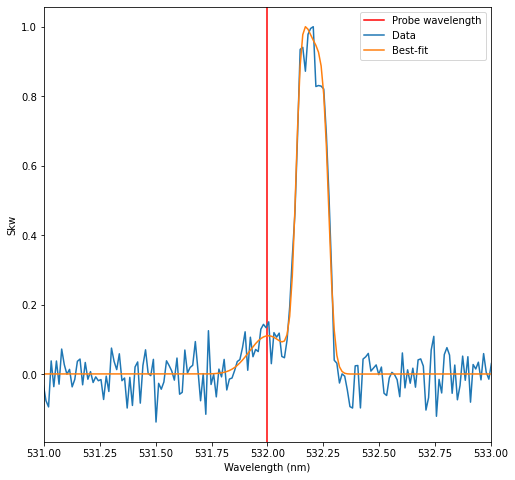

In [247]:
print(f"Best fit parameters:\n{result.best_values}")
print(f"Number of fit iterations:{result.nfev}")
print(f"Reduced Chisquared:{result.redchi:.4f}")

# Extract the best fit curve
best_fit_skw = iaw_result.best_fit

# Plot
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Skw")
ax.axvline(x=probe_wavelength.value, color='red', label='Probe wavelength')
    
ax.set_xlim(531, 533)

ax.plot(iaw_wavelengths.value, iaw_skw, label='Data')
ax.plot(iaw_wavelengths.value, best_fit_skw, label='Best-fit')
ax.legend(loc='upper right')

At this point, the best-fit parameters from the IAW fit could be used to further refine the EPW fit, and so on until both fits are acceptable.

## Estimating Errors in Fits

`lmfit` can also be used to estimate the errors in the fit parameters. One method of doing so is the [`lmfit.conf_interval`](https://lmfit.github.io/lmfit-py/confidence.html#confidence-chapter) function, which estimates the confidence interval by varying the parameters around their best-fit values

In [280]:
iaw_result.ci_out = None
iaw_ci = iaw_result.conf_interval(sigmas=[3], p_names=['ifract_0', 'ion_speed_1'], maxiter=200)
print(iaw_ci)

OrderedDict([('ifract_0', [(0.9973002039367398, 0.20444722175729318), (0.0, 0.3256831123028531), (0.9973002039367398, 0.4416913294634632)]), ('ion_speed_1', [(0.9973002039367398, 195511.32227223832), (0.0, 198762.04239246965), (0.9973002039367398, 202111.0870143359)])])


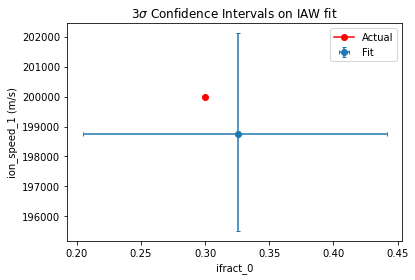

In [281]:
ifract0m3 = iaw_ci['ifract_0'][0][1]
ifract0_fit = iaw_ci['ifract_0'][1][1]
ifract0p3 = iaw_ci['ifract_0'][2][1]

ionspeed1m3 = iaw_ci['ion_speed_1'][0][1]
ionspeed1_fit = iaw_ci['ion_speed_1'][1][1]
ionspeed1p3 = iaw_ci['ion_speed_1'][2][1]

# Format the errorbars for input to matplotlib.errorbar
xerr = np.array([[ifract0_fit-ifract0m3], [ifract0p3-ifract0_fit]])
yerr  = np.array([[ionspeed1_fit-ionspeed1m3], [ionspeed1p3-ionspeed1_fit]])

fig, ax = plt.subplots()
ax.set_title("3$\sigma$ Confidence Intervals on IAW fit")
ax.set_xlabel("ifract_0")
ax.set_ylabel("ion_speed_1 (m/s)")

ax.plot(ifract[0], ion_vel[1][0].si.value, marker='o', color='red', label='Actual')
ax.errorbar(ifract0_fit, ionspeed1_fit, yerr=yerr, xerr=xerr, fmt='o', capsize=2, label='Fit')
ax.legend()

Lets repeat the same procedure for the EPW fit

In [277]:
epw_result.ci_out = None
epw_ci = epw_result.conf_interval(sigmas=[3], p_names=['n', 'Te_0'], maxiter=200)
print(epw_ci)

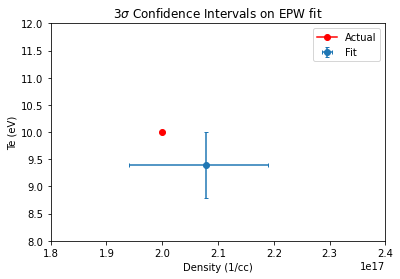

In [278]:
nm3 = epw_ci['n'][0][1]
n_fit = epw_ci['n'][1][1]
np3 = epw_ci['n'][2][1]

Tem3 = epw_ci['Te_0'][0][1]
Te_0_fit = epw_ci['Te_0'][1][1]
Tep3 = epw_ci['Te_0'][2][1]

# Format the errorbars for input to matplotlib.errorbar
yerr  = np.array([[Te_0_fit-Tem3], [Tep3-Te_0_fit]])
xerr = np.array([[n_fit-nm3], [np3-n_fit]])


fig, ax = plt.subplots()
ax.set_title("3$\sigma$ Confidence Intervals on EPW fit")
ax.set_xlabel("Density (1/cc)")
ax.set_ylabel("Te (eV)")

ax.set_xlim(1.8e17, 2.4e17)
ax.set_ylim(8, 12)
ax.plot(n.value, Te.value, marker='o', color='red', label='Actual')
ax.errorbar(n_fit, Te_0_fit, yerr=yerr, xerr=xerr, fmt='o', capsize=2, label='Fit')
ax.legend()

A better (but much more computationally intensive) alternative is to use a Markov Chain Monte Carlo method to more fully explore the parameter space.

To calculate confidence intervals, use an MCMC algorithm starting at the best-fit values

In [65]:
Ti_0_fit = result.best_values['Ti_0']
Ti_1_fit = result.best_values['Ti_1']
ifract_0_fit = result.best_values['ifract_0']
ifract_1_fit = result.best_values['ifract_1']
ion_speed_1_fit = result.best_values['ion_speed_1']


In [67]:
emcee_params = Parameters()
emcee_params.add('n', value=n_fit, vary=False)
emcee_params.add('Te_0', value=Te_0_fit, vary=False)
emcee_params.add('Ti_0', value=Ti_0_fit, vary=True, min=15, max=25)
emcee_params.add('Ti_1', value=Ti_1_fit, vary=True, min=45, max=55)
emcee_params.add('ifract_0', value=ifract_0_fit, vary=False, min=0.2, max=0.8)
emcee_params.add('ifract_1', value=ifract_1_fit, vary=False, min=0.2, max=0.8, expr='1.0 - ifract_0')
emcee_params.add('ion_speed_0', value=0, vary=False)
emcee_params.add('ion_speed_1', value=ion_speed_1_fit, vary=True, min=0, max=1e6)


model = thomson.thomson_model(iaw_wavelengths, settings, emcee_params)


emcee_kws = dict(steps=1000, burn=300, thin=20, is_weighted=False,
             progress=True)

emcee_result = model.fit(iaw_skw, params=emcee_params, wavelengths=iaw_wavelengths,  method='emcee', fit_kws=emcee_kws)

100%|██████████| 1000/1000 [42:34<00:00,  2.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [ 71.15322111  95.50091639  76.18752169 129.44375584]


In [68]:
emcee_result.fit_report()

"[[Model]]\n    Model(<lambda>)\n[[Fit Statistics]]\n    # fitting method   = emcee\n    # function evals   = 100000\n    # data points      = 512\n    # variables        = 4\n    chi-square         = 461.174220\n    reduced chi-square = 0.90782327\n    Akaike info crit   = -45.5289529\n    Bayesian info crit = -28.5756544\n[[Variables]]\n    n:                 1.999952e+17 (fixed)\n    Te_0:              10.00014 (fixed)\n    Ti_0:              20.8622554 +/- 2.10330126 (10.08%) (init = 21.21293)\n    Ti_1:              48.1675488 +/- 1.68938220 (3.51%) (init = 48.48871)\n    ifract_0:          0.3087156 (fixed)\n    ifract_1:          0.69128441 == '1.0 - ifract_0'\n    ion_speed_0:       0 (fixed)\n    ion_speed_1:       200018.179 +/- 390019.958 (194.99%) (init = 199774.3)\n    efract_0:          1 (fixed)\n    electron_speed_0:  0 (fixed)\n    __lnsigma:        -4.69847082 +/- 1.53538948 (32.68%) (init = 0.01)\n[[Correlations]] (unreported correlations are < 0.100)\n    C(ion_spee

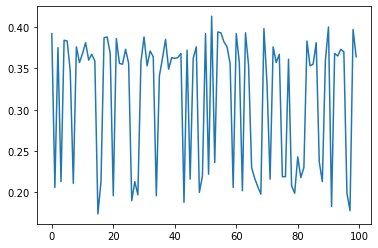

In [69]:
plt.plot(emcee_result.acceptance_fraction)

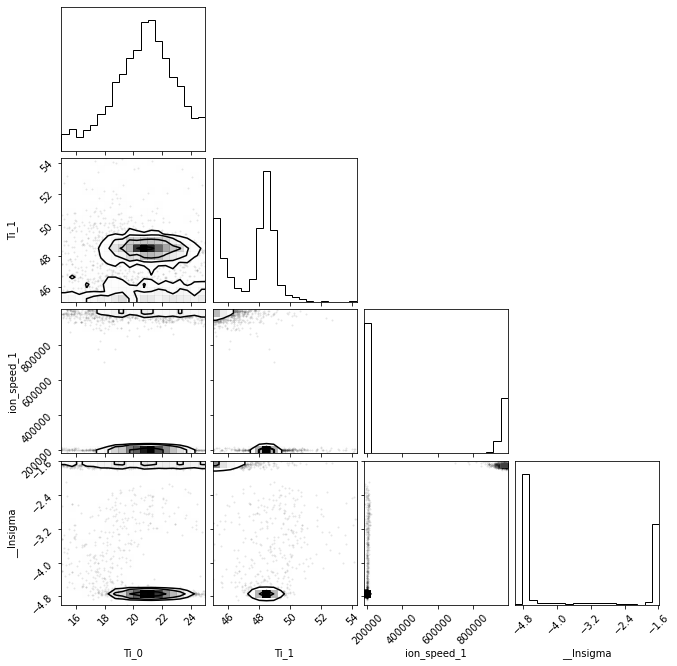

In [70]:
emcee_corner = corner.corner(emcee_result.flatchain, labels=emcee_result.var_names,
                             truths=list(emcee_result.params.valuesdict().values()))

In [ ]:
emcee_result.fit_report()